<a href="https://colab.research.google.com/github/rushikeshnakhate/PortfoliOpt/blob/master/multi_optimized_df_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
import yfinance as yf
import pandas as pd
import numpy as np
from pathlib import Path
import os
output_dir = Path("/content/drive/MyDrive/")
data_dir = Path("/content/drive/MyDrive/data")
import matplotlib.pyplot as plt
# !pip install tqdm
# !pip install PyPortfolioOpt
# !pip install tabulate
# !pip install dtale
# !pip install -q data-table
import scipy.optimize as sci_opt
from tqdm import tqdm  # Import the tqdm progress b
from google.colab import data_table

In [122]:
import tarfile

def unzip_files():
  from google.colab import files
  import zipfile

  # After uploading, you can unzip the file
  import zipfile
  import os


  # zip_filename = '/content/drive/MyDrive/data.zip'
  # # Replace 'data.zip' with the name of your uploaded zip file
  # with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
  #     zip_ref.extractall(output_dir)

  tar_filename = '/content/drive/MyDrive/data.tar.gz'
  with tarfile.open(tar_filename, 'r:gz') as tar_ref:
    tar_ref.extractall(output_dir)

  print("Directory uploaded and extracted successfully to Google Drive.")
# unzip_files()

In [123]:
# ! rm -rf output_dir/MyDrive/*pkl
# ! ls -lrt output_dir/MyDrive/*pkl
# ! rm -rf  /content/drive/MyDrive/data


monte_carol_pkl_filepath = os.path.join(data_dir, "monte_carlo_pkl_filename.pkl")
short_listed_monte_carol_pkl_filepath = os.path.join(data_dir, "short_listed_monte_pkl_filename.pkl")
short_listed_monte_carol_df =  pd.read_pickle(short_listed_monte_carol_pkl_filepath)

In [124]:
from datetime import datetime, timedelta
def generate_month_date_ranges(year, months=None):
    """Generate start_date and end_date (without time) for each month in the specified year.

    Args:
        year (int): The year for which to generate the month ranges.
        months (list of int, optional): Specific months to generate ranges for (1-12).

    Returns:
        list of tuples: Each tuple contains the start and end date for the specified months.
    """
    if months is None:
        months = range(1, 13)  # Default to all months if none specified

    month_ranges = []
    for month in months:
        start_date = datetime(year, month, 1).date()
        if month == 12:
            end_date = (datetime(year + 1, 1, 1) - timedelta(days=1)).date()
        else:
            end_date = (datetime(year, month + 1, 1) - timedelta(days=1)).date()
        month_ranges.append((start_date, end_date))

    return month_ranges

def create_current_month_directory(start_date, output_dir):
    current_month = start_date.strftime("%Y%m")
    current_month_dir = output_dir / current_month
    # current_month_dir.rmdir(parents=True, exist_ok=True)
    return current_month_dir

In [125]:

def load_data_and_plot(start_date, data_dir, plot_func):
    """
    Function to load data for a specific date range and plot using the given plot function.

    Args:
    start_date (datetime): The start date of the month for data loading.
    data_dir (str): The directory where the data is stored.
    plot_func (function): A function to plot the data (either bar plot or 3D plot).
    """
    current_month_dir = create_current_month_directory(start_date, data_dir)
    data_pkl_filepath = os.path.join(current_month_dir, "data.pkl")
    expected_return_pkl_filepath = os.path.join(current_month_dir, "expected_return.pkl")
    optimization_pkl_filepath = os.path.join(current_month_dir, "optimization.pkl")

    # Load data
    data = pd.read_pickle(data_pkl_filepath)
    expected_return_df = pd.read_pickle(expected_return_pkl_filepath)
    optimization_df = pd.read_pickle(optimization_pkl_filepath)

    # Format the month as 'YYYY-MM' for the title
    current_month = start_date.strftime('%Y-%m')
    # Call the provided plot function
    # print("using optimization_pkl_filepath=optimization_pkl_filepath{}".format(optimization_pkl_filepath))
    return plot_func(optimization_df)

In [173]:
import matplotlib.pyplot as plt
import math

# Function to calculate performance and plot pie charts for the best and worst portfolios
def get_performance_and_plot_pie(df1, number_of_top=2):
    df = df1.copy()
    # Normalize the columns (Expected Annual Return, Annual Volatility, Sharpe Ratio)
    df['Return_Score'] = df['Expected Annual Return'] / df['Expected Annual Return'].max()
    df['Volatility_Score'] = df['Annual Volatility'].max() / df['Annual Volatility']  # Inverted because lower is better
    df['Sharpe_Score'] = df['Sharpe Ratio'] / df['Sharpe Ratio'].max()

    # Combine the scores into a total score (adjust weights as needed)
    df['Total_Score'] = df['Return_Score'] + df['Volatility_Score'] + df['Sharpe_Score']

    # Get the top 2 best portfolios
    top_best = df.nlargest(number_of_top, 'Total_Score')

    # Get the bottom 2 worst portfolios
    bottom_worst = df.nsmallest(number_of_top, 'Total_Score')

    return top_best, bottom_worst

In [166]:
# Function to plot pie charts for portfolios (top or bottom) with dynamically calculated grid layout
def plot_portfolios(df, start_date, portfolio_type="top"):
    """
    Plots pie charts for the portfolios' weight allocations and shows their details below each chart,
    with increased pie chart size.

    Parameters:
    df (pd.DataFrame): The dataframe containing the portfolios (either top or bottom)
    portfolio_type (str): Specifies whether it's "top" or "bottom" portfolio
    """
    # Determine the number of portfolios to plot
    num_portfolios = len(df)

    # Calculate number of rows and columns dynamically
    ncols = 2  # Keep two columns for side-by-side plotting
    nrows = math.ceil(num_portfolios / ncols)  # Number of rows is based on number of portfolios

    # Set up the grid layout for the subplots, dynamically adjusting figure size
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 3.5))

    # Flatten the axs array to easily iterate over it (even for 2D grid)
    axs = axs.flatten()

    for i in range(num_portfolios):
        # Get portfolio's weights and details
        weights_dict = df.iloc[i]['Weights']
        if isinstance(weights_dict, str):
            weights_dict = eval(weights_dict)
        weights_dict = {k: v for k, v in weights_dict.items() if v > 0}

        # Plot portfolio pie chart with increased size and reduced ticker font size
        tickers = list(weights_dict.keys())
        weights = list(weights_dict.values())
        axs[i].pie(weights, labels=tickers, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 8}, radius=1.2)
        axs[i].set_title(f'{start_date} {portfolio_type.capitalize()} Portfolio at Index {df.index[i]}', fontsize=10)
        axs[i].axis('equal')

        # Create a text block with portfolio details below the pie chart
        optimizer_type = df.iloc[i].get('Optimizer', 'N/A')  # Assuming 'Optimizer' is the column name
        return_type = df.iloc[i].get('Expected Return Type', 'N/A')    # Assuming 'Expected Return Type' is the column name
        risk_type = df.iloc[i].get('Risk Model', 'N/A')        # Assuming 'Risk Model' is the column name

        # Format the text string with these details
        text_str = f"Expected Return Type: {return_type}\nRisk Model: {risk_type}\nOptimizer: {optimizer_type}"

        # Add text below the pie chart
        axs[i].text(0.5, -0.4, text_str, ha='center', fontsize=8, transform=axs[i].transAxes, bbox=dict(facecolor='white', alpha=0.7))

    # Turn off any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    # Adjust layout with more control for spacing
    plt.subplots_adjust(hspace=0.6, wspace=0.3)

    # Show the plot
    plt.show()

# Example usage:
# top_best, bottom_worst = get_performance_and_plot_pie(optimized_df_cleaned)
# plot_portfolios(top_best, start_date="2023-01-01", portfolio_type="top")
# plot_portfolios(bottom_worst, start_date="2023-01-01", portfolio_type="bottom")

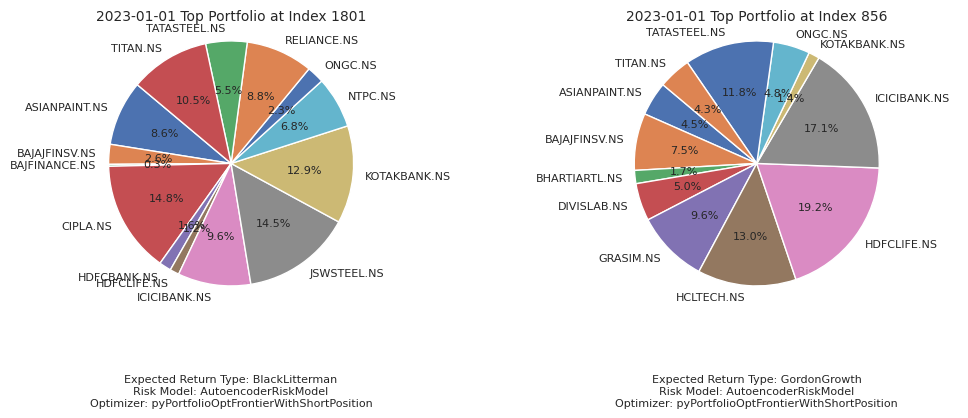

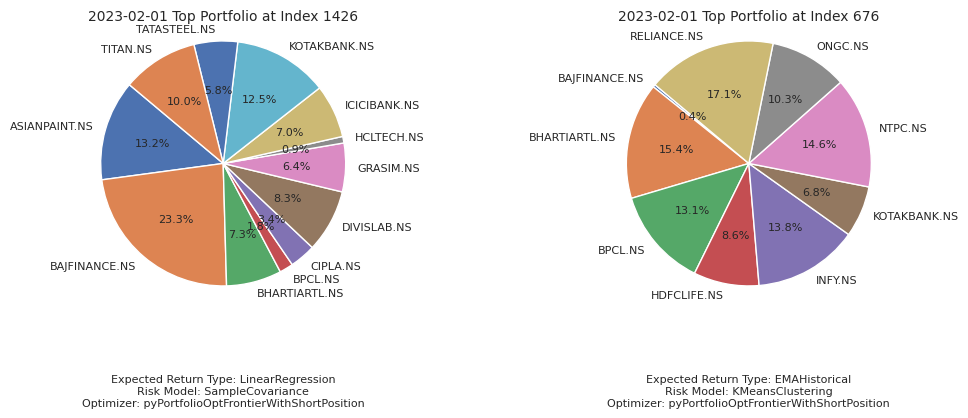

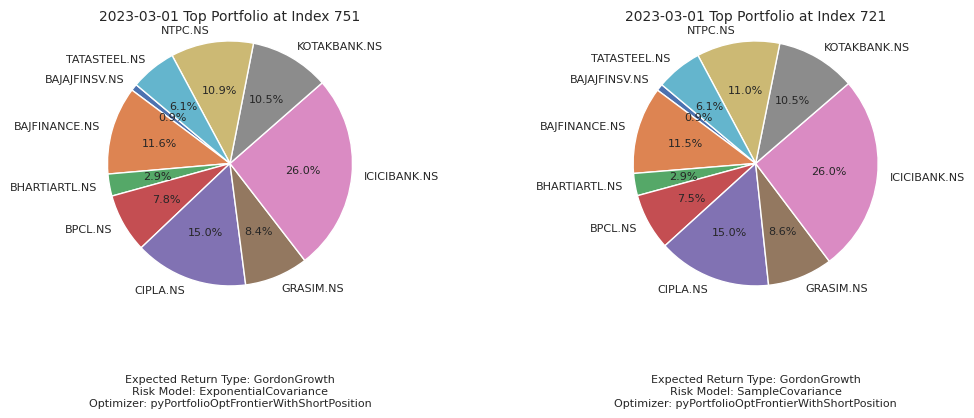

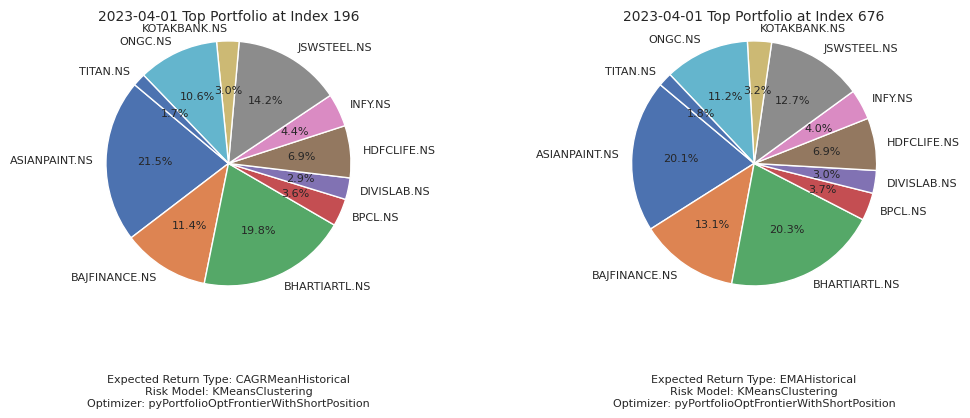

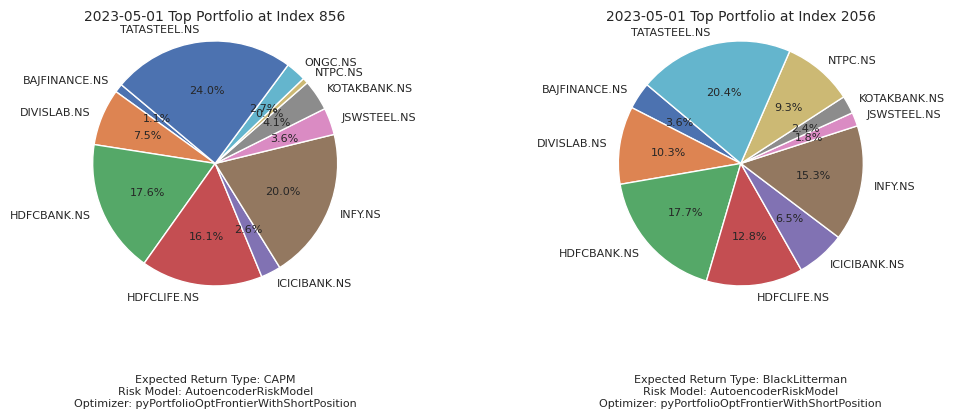

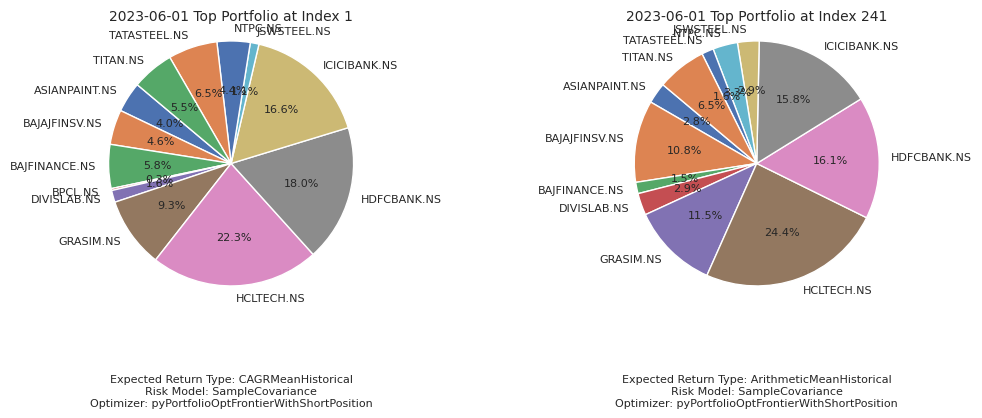

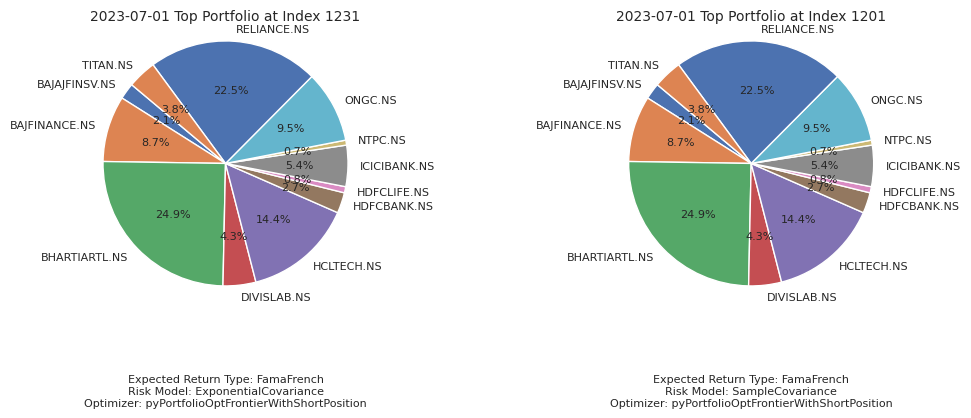

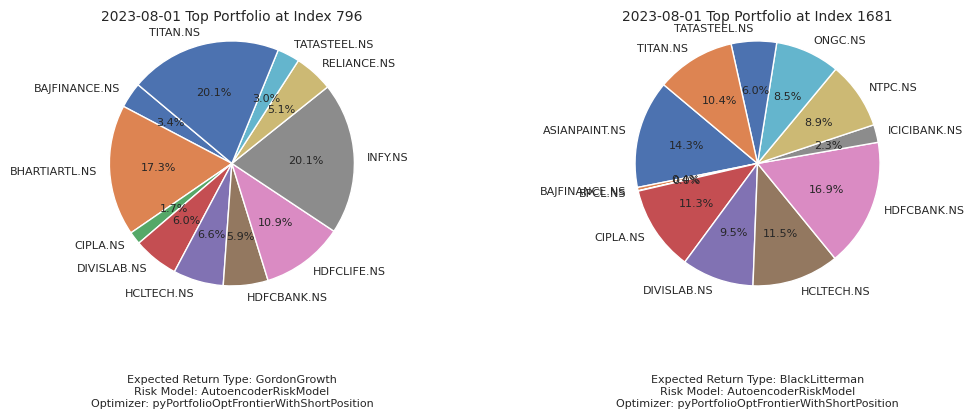

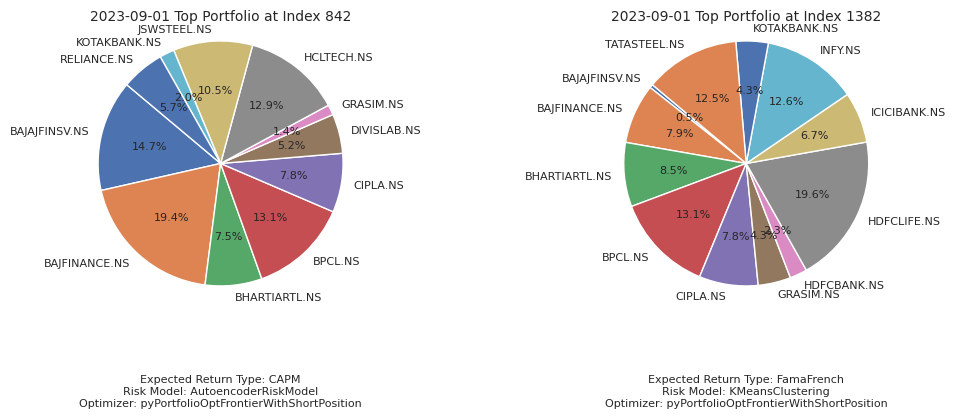

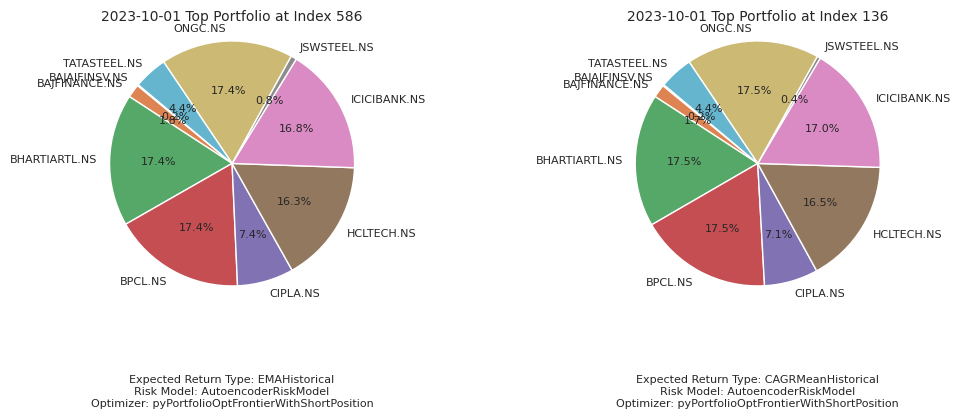

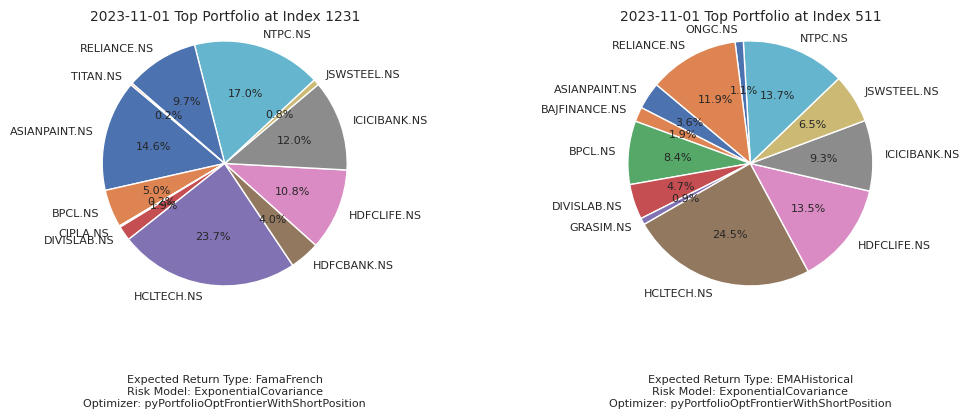

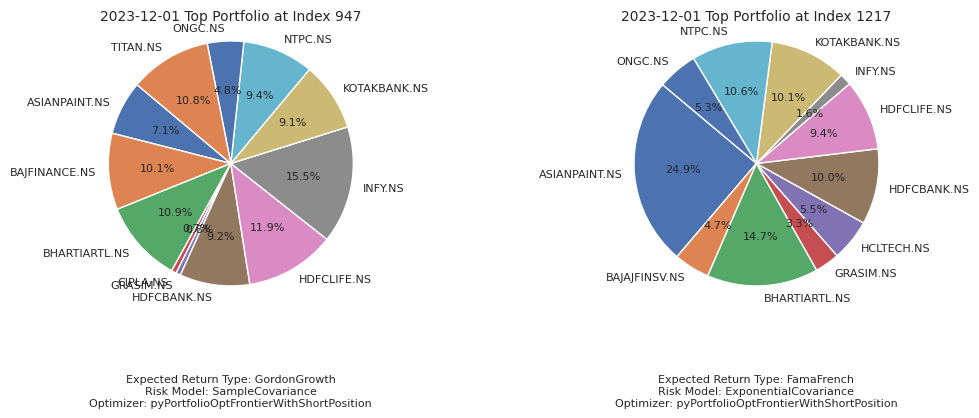

In [174]:
if __name__ == "__main__":
    year = 2023
    # Generate date ranges for alternate months in 2023 (Jan, Mar, May, Jul, Sep, Nov)
    # plot generate current and next month
    month_ranges = generate_month_date_ranges(year)

    # # Plot all bar charts first
    for start_date, end_date in month_ranges:
       top_best, bottom_worst = load_data_and_plot(start_date, data_dir, get_performance_and_plot_pie)
       plot_portfolios(top_best,start_date,"top")

In [169]:
import pandas as pd

# Function to rank portfolios based on Expected Annual Return, Annual Volatility, and Sharpe Ratio
def rank_portfolios(top_best_df, monte_carlo_df):
    """
    Compare and rank portfolios from top_best and monte_carlo DataFrames based on:
    - Higher Expected Annual Return
    - Lower Annual Volatility
    - Higher Sharpe Ratio

    Parameters:
    - top_best_df: DataFrame containing the top best portfolios
    - monte_carlo_df: DataFrame containing the Monte Carlo simulation results

    Returns:
    - DataFrame showing the ranking for each metric and overall ranking.
    """
    # Concatenate the two DataFrames
    combined_df = pd.concat([top_best_df, monte_carlo_df], ignore_index=True)

    # Rank portfolios based on metrics
    combined_df['Return_Rank'] = combined_df['Expected Annual Return'].rank(ascending=False)
    combined_df['Volatility_Rank'] = combined_df['Annual Volatility'].rank(ascending=True)  # Lower volatility is better
    combined_df['Sharpe_Rank'] = combined_df['Sharpe Ratio'].rank(ascending=False)

    # Calculate overall rank by summing the ranks (lower score is better)
    combined_df['Overall_Rank'] = combined_df['Return_Rank'] + combined_df['Volatility_Rank'] + combined_df['Sharpe_Rank']

    # Sort by the overall rank
    ranked_df = combined_df.sort_values(by='Overall_Rank')

    return ranked_df


def drop_uncommon_columns(df1, df2):
    """
    Drops columns that are not common between two DataFrames.

    Parameters:
    - df1: The first DataFrame (e.g., short_listed_monte_carol_df)
    - df2: The second DataFrame (e.g., top_best)

    Returns:
    - Two DataFrames with only the common columns.
    """
    # Get the common columns between the two DataFrames
    common_columns = df1.columns.intersection(df2.columns)

    # Filter both DataFrames to only include the common columns
    df1_common = df1[common_columns]
    df2_common = df2[common_columns]

    return df1_common, df2_common


# ranked_result = rank_portfolios(top_best, short_listed_monte_carol_df)
# short_listed_monte_carol_common, top_best_common = drop_uncommon_columns(short_listed_monte_carol_df, top_best)
# ranked_result = rank_portfolios(short_listed_monte_carol_common,top_best_common)

# print(ranked_result)

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot comparison between Monte Carlo and Top Best portfolios
def plot_comparison(all_months_ranked_df):
    """
    Plot the comparison of Monte Carlo and Top Best portfolios based on:
    - Expected Annual Return
    - Annual Volatility
    - Sharpe Ratio

    Parameters:
    - all_months_ranked_df: DataFrame containing the ranked portfolios for all months
    """
    # Create a 'Category' column to differentiate between Monte Carlo and Top Best portfolios
    all_months_ranked_df['Category'] = all_months_ranked_df['Optimizer'].apply(lambda x: 'Monte Carlo' if 'monte_carlo' in x else 'Top Best')

    # Set the plotting style
    sns.set(style="whitegrid")

    # Create subplots for Expected Annual Return, Annual Volatility, and Sharpe Ratio
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))  # Increased figure size

    # Plot Expected Annual Return
    sns.barplot(x='Month', y='Expected Annual Return', hue='Category', data=all_months_ranked_df, ax=axes[0])
    axes[0].set_title('Comparison of Expected Annual Return')
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel('Expected Annual Return')
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Plot Annual Volatility
    sns.barplot(x='Month', y='Annual Volatility', hue='Category', data=all_months_ranked_df, ax=axes[1])
    axes[1].set_title('Comparison of Annual Volatility')
    axes[1].set_xlabel('Month')
    axes[1].set_ylabel('Annual Volatility')
    axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Plot Sharpe Ratio
    sns.barplot(x='Month', y='Sharpe Ratio', hue='Category', data=all_months_ranked_df, ax=axes[2])
    axes[2].set_title('Comparison of Sharpe Ratio')
    axes[2].set_xlabel('Month')
    axes[2].set_ylabel('Sharpe Ratio')
    axes[2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Adjust the layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()
# Assuming you have the DataFrame `all_months_ranked_df`


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

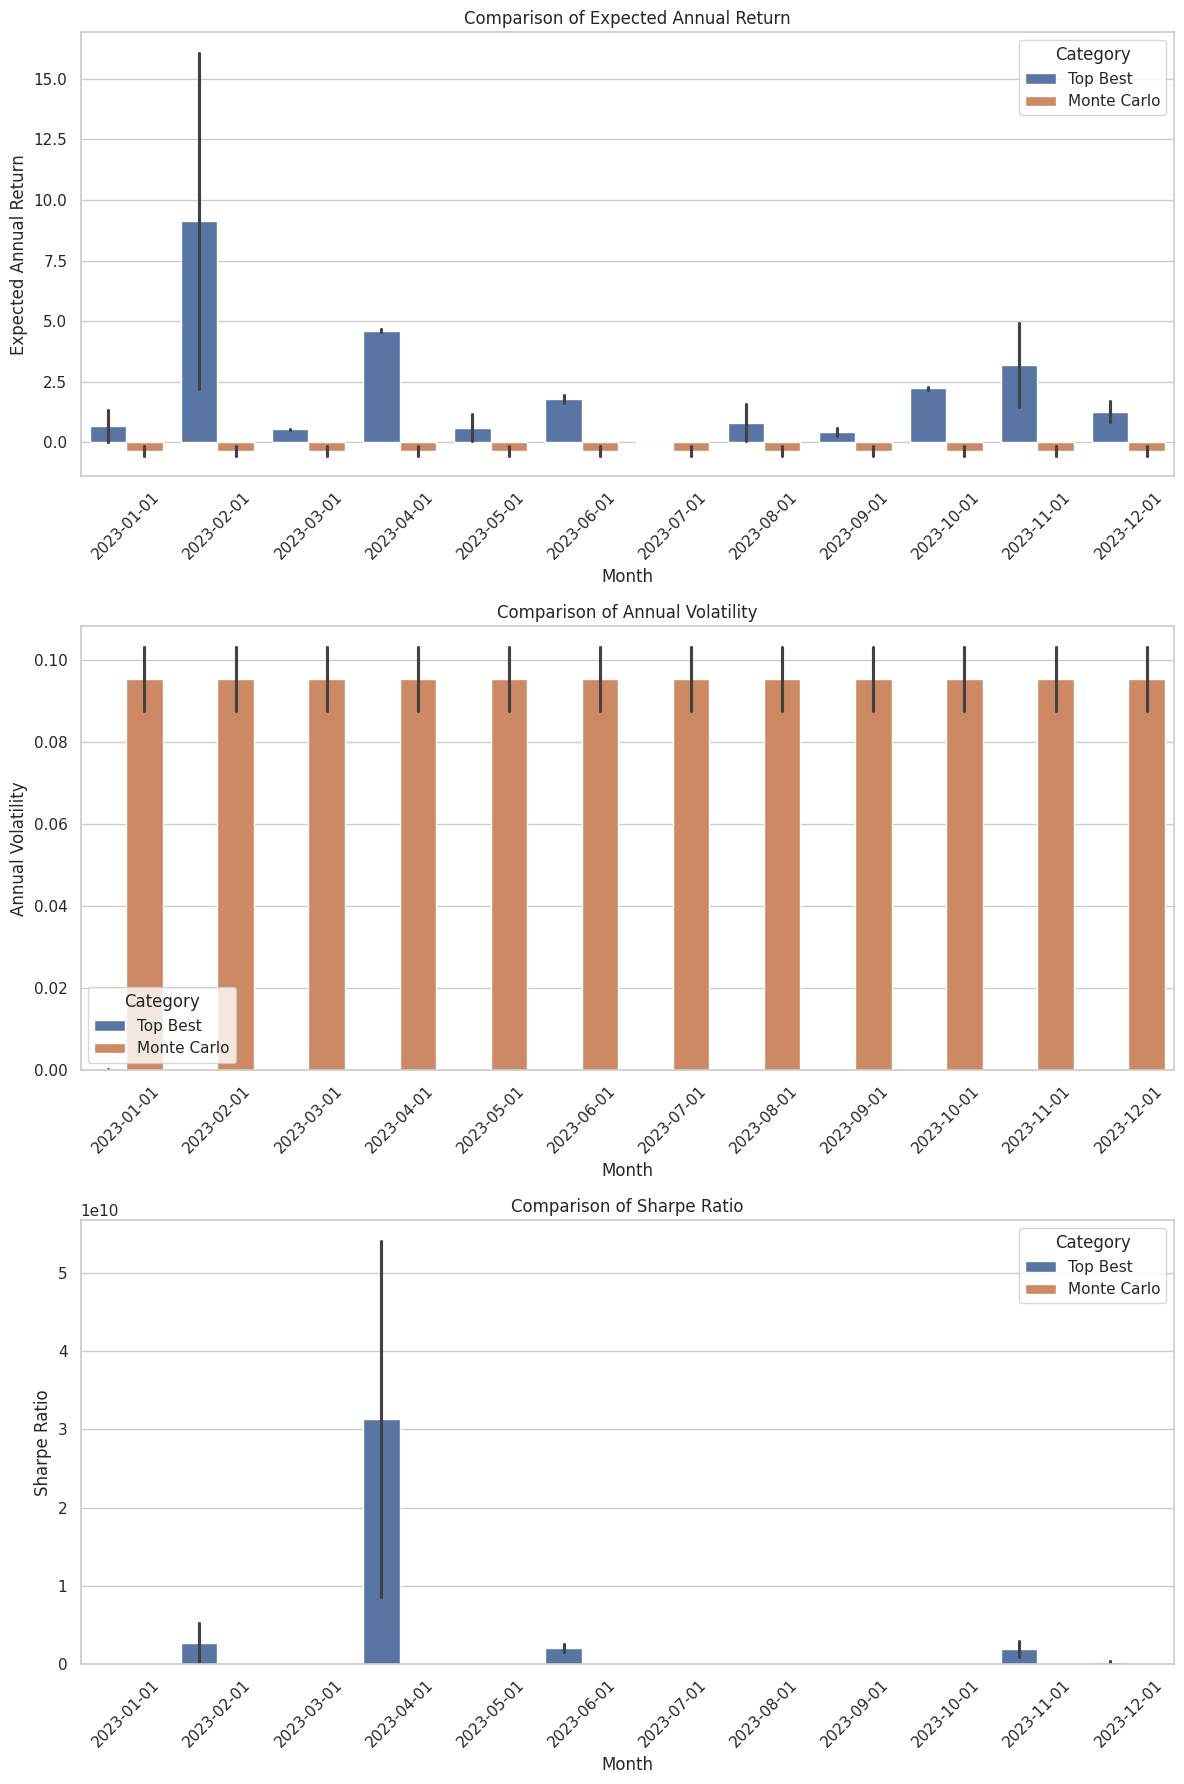

In [176]:
if __name__ == "__main__":
    year = 2023
    all_ranked_results = []  # List to store results for each month

    # Generate date ranges for alternate months in 2023 (Jan, Mar, May, Jul, Sep, Nov)
    month_ranges = generate_month_date_ranges(year)  # Assuming this function is defined

    # Loop over the months and compare each month's top_best with Monte Carlo results
    for start_date, end_date in month_ranges:
        # Load the top and bottom portfolios for the month
        top_best, bottom_worst = load_data_and_plot(start_date, data_dir, get_performance_and_plot_pie)

        # Drop uncommon columns between top_best and monte_carlo_df
        short_listed_monte_carlo_common, top_best_common = drop_uncommon_columns(short_listed_monte_carol_df, top_best)

        # Rank the portfolios for the current month
        ranked_result = rank_portfolios(top_best_common, short_listed_monte_carlo_common)

        # Add a column for the month to keep track of the month for each portfolio
        ranked_result['Month'] = start_date

        # Append the ranked result for the current month to the list
        all_ranked_results.append(ranked_result)

    # Combine all monthly ranked results into a single DataFrame
    all_months_ranked_df = pd.concat(all_ranked_results, ignore_index=True)
    plot_comparison(all_months_ranked_df)
    # Optionally, print the combined result
    # print(all_months_ranked_df)

In [159]:
data_table.DataTable(all_months_ranked_df)

,Expected Annual Return,Annual Volatility,Sharpe Ratio,Weights,Expected Return Type,Risk Model,Optimizer,Return_Rank,Volatility_Rank,Sharpe_Rank,Overall_Rank,Month
0,1.321407,0.000215,6053.55005,"{'ASIANPAINT.NS': 0.21888, 'BAJAJFINSV.NS': 0....",GordonGrowth,AutoencoderRiskModel,pyPortfolioOptFrontierWithShortPosition,1.0,2.0,1.0,4.0,2023-01-01
1,0.035185,0.000049,309.334886,"{'ASIANPAINT.NS': 0.49576, 'BAJAJFINSV.NS': 0....",BlackLitterman,AutoencoderRiskModel,pyPortfolioOptFrontierWithShortPosition,2.0,1.0,2.0,5.0,2023-01-01
2,-0.149277,0.10295,-1.449992,"{'ASIANPAINT.NS': 0.008504191126940017, 'BAJAJ...",monte_carlo_max_sharpe_ratio,monte_carlo_max_sharpe_ratio,monte_carlo_max_sharpe_ratio,3.0,4.0,3.0,10.0,2023-01-01
3,-0.563956,0.087435,-6.45,"{'ASIANPAINT.NS': 0.020427736559914193, 'BAJAJ...",monte_carlo_min_annual_volatility,monte_carlo_min_annual_volatility,monte_carlo_min_annual_volatility,4.0,3.0,4.0,11.0,2023-01-01
4,16.076313,0.0,5218164609.758979,"{'ASIANPAINT.NS': 0.50896, 'BAJAJFINSV.NS': -0...",LinearRegression,SampleCovariance,pyPortfolioOptFrontierWithShortPosition,1.0,1.0,1.0,3.0,2023-02-01
5,2.20147,0.0,331567208.813166,"{'ASIANPAINT.NS': -0.51786, 'BAJAJFINSV.NS': -...",EMAHistorical,KMeansClustering,pyPortfolioOptFrontierWithShortPosition,2.0,2.0,2.0,6.0,2023-02-01
6,-0.149277,0.10295,-1.449992,"{'ASIANPAINT.NS': 0.008504191126940017, 'BAJAJ...",monte_carlo_max_sharpe_ratio,monte_carlo_max_sharpe_ratio,monte_carlo_max_sharpe_ratio,3.0,4.0,3.0,10.0,2023-02-01
7,-0.563956,0.087435,-6.45,"{'ASIANPAINT.NS': 0.020427736559914193, 'BAJAJ...",monte_carlo_min_annual_volatility,monte_carlo_min_annual_volatility,monte_carlo_min_annual_volatility,4.0,3.0,4.0,11.0,2023-02-01
8,0.52455,0.0,67294660.146569,"{'ASIANPAINT.NS': -0.26063, 'BAJAJFINSV.NS': 0...",GordonGrowth,ExponentialCovariance,pyPortfolioOptFrontierWithShortPosition,2.0,1.0,1.0,4.0,2023-03-01
9,0.541621,0.0,13180960.055585,"{'ASIANPAINT.NS': -0.2587, 'BAJAJFINSV.NS': 0....",GordonGrowth,SampleCovariance,pyPortfolioOptFrontierWithShortPosition,1.0,2.0,2.0,5.0,2023-03-01
